# Классификация заголовков новостей

**Требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.**

In [20]:
import pandas as pd
import numpy as np
import string
import re
import scipy.stats as st
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

import nltk
from nltk.stem import *
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
from nltk import word_tokenize
stemmer = SnowballStemmer("russian") 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д'])

from pymystem3 import Mystem
mystem = Mystem() 

from string import punctuation

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from numpy.random import RandomState
state = np.random.RandomState(12345)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Откроем файл - изучим данные

In [2]:
def review(df): 
    """функция для отображения общей информации"""
    info = display(df.head(10)), df.info()
    if df.duplicated().sum() == 0:
        print('Дубликатов не обнаружено')
    else:
        print('Дубликатов найдено: {}'.format(df.duplicated().sum()))
        
def str_corpus(corpus):
    """функция для получения текстовой строки из списка слов"""
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

def get_corpus(data):
    """функция получения списка всех слов в корпусе"""
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

def get_wordCloud(corpus):
    """функция получения облака слов"""
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

def procWordCloud(df):
    """визуализация облака слов"""
    corpus = get_corpus(df.values)
    procWordCloud = get_wordCloud(corpus)
    fig = plt.figure(figsize=(30,30))
    plt.subplot(1, 2, 1)
    plt.imshow(procWordCloud)
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.show()
    print('Количество уникальных слов - {}'.format(len(corpus)))

In [3]:
train = pd.read_csv('train.tsv', sep='\t')

In [4]:
test = pd.read_csv('test.tsv', sep='\t')

In [5]:
review(train) # 0 – новость реальная; 1 – новость выдуманная

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем...,0
9,Microsoft объявила дату выхода очков дополненн...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB
Дубликатов найдено: 1


In [6]:
train['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

### Вывод

- в данных обнаружен дубликат;
- классы сбалансированы.

## Предобработка данных

In [7]:
train = train.drop_duplicates().reset_index(drop = True)

In [8]:
def remove_punct(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

train['title'] = train['title'].map(lambda x: x.lower())
train['title'] = train['title'].map(lambda x: remove_punct(x))
train['title'] = train['title'].map(lambda x: x.split(' '))
train['title'] = train['title'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                               and token != " " \
                                               and token.strip() not in punctuation])
train['title'] = train['title'].map(lambda x: ' '.join(x))

In [9]:
print('Дубликатов найдено: {}'.format(train.duplicated().sum()))

Дубликатов найдено: 0


### Вывод

- выборка очищена от дубликатов;
- данные столбца `title` приведены к нижнему регистру;
- данные столбца `title` очищены от слов паразитов и знаков пунктуации.

## Исследовательский анализ

### Посмотрим на уникальные слова всей выборки

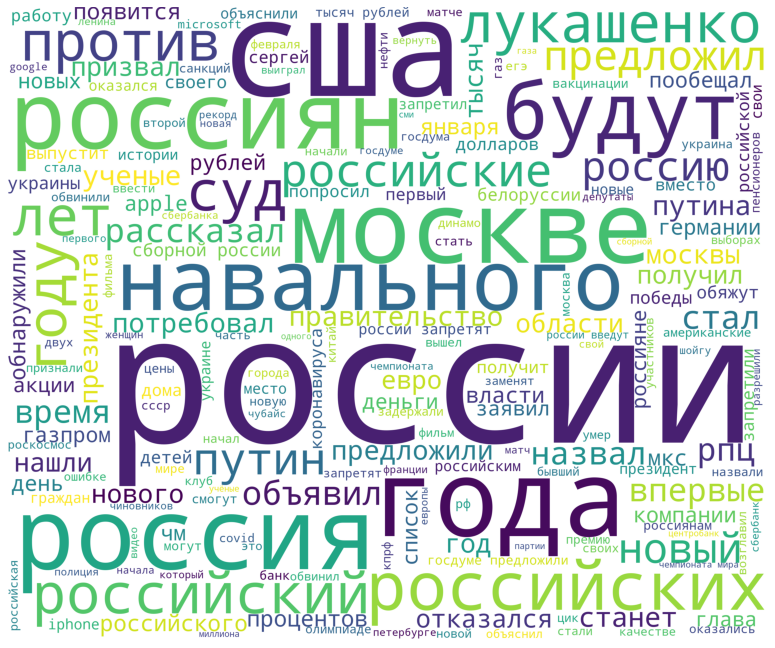

Количество уникальных слов - 42099


In [10]:
procWordCloud(train['title'])

### Посмотрим на уникальные слова только правдивых новостей

In [11]:
true_news = train.loc[train['is_fake'] == 0]

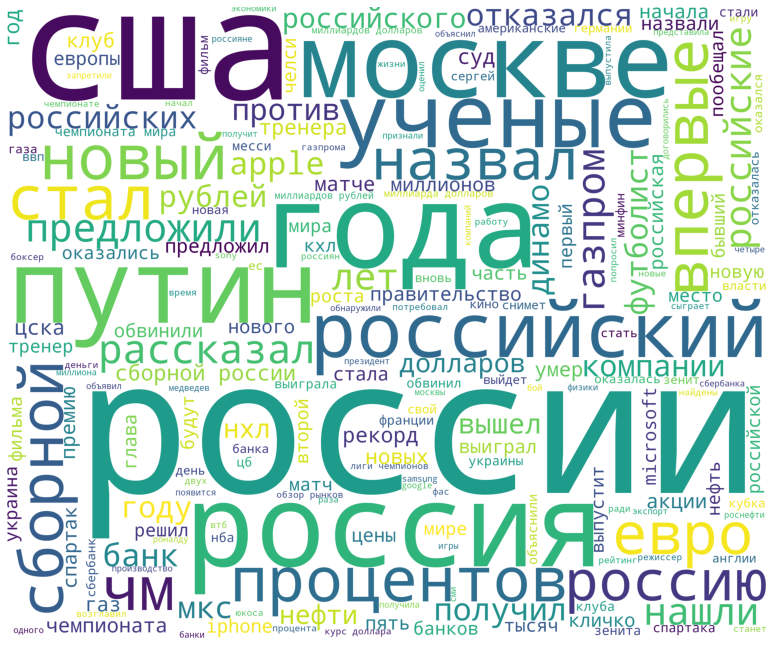

Количество уникальных слов - 18083


In [12]:
procWordCloud(true_news['title'])

### Посмотрим на уникальные слова только фейковых новостей

In [13]:
fake_news = train.loc[train['is_fake'] == 1]

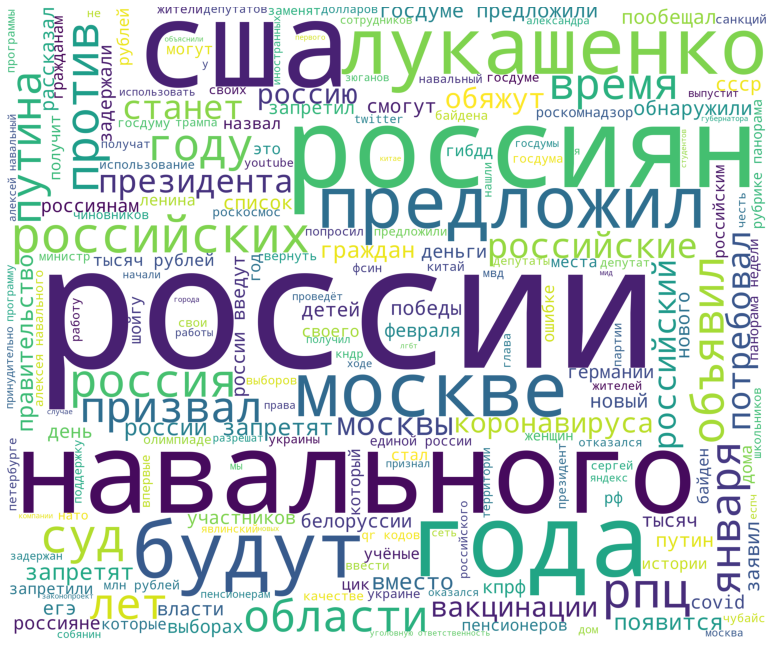

Количество уникальных слов - 24016


In [14]:
procWordCloud(fake_news['title'])

### Вывод

- полная выборка содержит `42099` уникальных слов;
- правдимые новости содержат `18083` уникальных слова, среди которых выражаются - `США`, `Москва`, `Ученые`, `Путин`, `Россия`;
- фейковые новости содержат `24016` уникальных слова, среди которых выражаются - `США`, `Россия`, `Навальный`, `Лукашенко`, `Москва`.

## Лемитизация

In [15]:
lemm_texts_list = []
for text in tqdm(train['title']):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
    
train['title_lemm'] = lemm_texts_list

100%|██████████| 5757/5757 [2:20:04<00:00,  1.46s/it]  


## Обучим модели и оценим их качество.

Для обучения будем использовать сл. алгоритмы:
- Naive Bayes Classifier;
- Linear Support Vector Machine;
- Random Forest Classifier;
- Logistic Regression.

Во всех случаях также будем использовать методы:
- CountVectorizer;
- TfidfTransformer.

Качество моделей оценим кросс-валидацией с десятью блоками.

In [17]:
def model_quality(model, features, target):
    """функция оценки качества"""
    scores = cross_val_score(model, features, target, cv=10) 
    final_score = sum(scores) / len(scores)
    return final_score

### Подготовим признаки

In [18]:
features = train['title_lemm']
target = train['is_fake']

### Инициализируем `pipeline` для алгоритмов 

#### Naive Bayes Classifier

In [23]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])

#### Linear Support Vector Machine

In [26]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))
               ])

#### RandomForestClassifier

In [29]:
rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state = state,class_weight='balanced',n_jobs = -1))
               ])

#### Logistic Regression

In [32]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=300))
               ])

### Оценим качество

In [44]:
print('Качество модели Naive Bayes Classifier равно {}'.format(model_quality(nb, features, target)))
print('Качество модели Linear Support Vector Machine равно {}'.format(model_quality(sgd, features, target)))
print('Качество модели Random Forest Classifier равно {}'.format(model_quality(rf, features, target)))
print('Качество модели Logistic Regression равно {}'.format(model_quality(logreg, features, target)))

Качество модели Naive Bayes Classifier равно 0.8521796497584541
Качество модели Linear Support Vector Machine равно 0.8311579106280194
Качество модели Random Forest Classifier равно 0.8005875603864734
Качество модели Logistic Regression равно 0.8322062198067632


### Вывод

Проверку на тестовой выборке будем проводить моделью `nb` - наивный байесовский классификатор. Обучим модель на тренировочной выборке.

In [40]:
nb.fit(features, target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

## Проверка модели на тестовой выборке

In [45]:
def predic(df):
    """фукнкция предсказания"""
    df['for_predict'] = df['title']
    df['for_predict'] = df['for_predict'].map(lambda x: x.lower())
    df['for_predict'] = df['for_predict'].map(lambda x: remove_punct(x))
    df['for_predict'] = df['for_predict'].map(lambda x: x.split(' '))
    df['for_predict'] = df['for_predict'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                         and token != " " \
                                                         and token.strip() not in punctuation])
    df['for_predict'] = df['for_predict'].map(lambda x: ' '.join(x))
    lemm_texts_list = []
    for text in tqdm(df['for_predict']):
        try:
            text_lem = mystem.lemmatize(text)
            tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
            text = " ".join(tokens)
            lemm_texts_list.append(text)
        except Exception as e:
            print(e)
    df['title_lemm'] = lemm_texts_list
    predict = nb.predict(df['title_lemm'])
    predictions = df.copy(deep=True)
    predictions = predictions.drop(['is_fake', 'title_lemm', 'for_predict'], axis=1)
    predictions['is_fake'] = predict
    
    return predictions

In [46]:
predictions = predic(test)

100%|██████████| 1000/1000 [24:50<00:00,  1.49s/it]


### Сохраним выборку

In [49]:
predictions.to_csv('predictions.tsv', index=False) 